In [1]:
import psycopg2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('form5500_data/config.json') as f:
   conf = json.load(f)
   host = conf['host']
   database = conf['database']
   user = conf['user']
   passw = conf['passw']

In [3]:
conn_str = "host={} dbname={} user={} password={}".format(host, database, user, passw)

In [4]:
conn = psycopg2.connect(conn_str)

In [5]:
query = "SELECT sb.SB_TOT_PARTCP_CNT, sb.SB_EFF_INT_RATE_PRCNT, sb.SB_PLAN_YEAR_BEGIN_DATE, sb.SB_FNDNG_SHORT_IND, \
       sb.SB_PR_YR_FNDNG_PRCNT, sb.SB_FNDNG_TGT_PRCNT, sb.SB_TOT_FNDNG_TGT_AMT, sb.SB_CURR_VALUE_AST_01_AMT, sb.SB_PLAN_TYPE_CODE \
FROM sb_full sb;"

In [6]:
eda_df = pd.read_sql(query, con=conn)

In [7]:
eda_df.groupby('sb_plan_type_code')['sb_plan_type_code'].count()

sb_plan_type_code
1    222660
2       451
3       769
Name: sb_plan_type_code, dtype: int64

<h3>Add calculated FS (using MVA instead of AVA) column</h3>

In [8]:
eda_df['mva_fs'] = eda_df['sb_curr_value_ast_01_amt'] / eda_df['sb_tot_fndng_tgt_amt'] *100

<h3>Add year column (year only of plan year begin date) </h3>

In [9]:
eda_df['plan_year_dt'] = pd.to_datetime(eda_df['sb_plan_year_begin_date'])

In [10]:
eda_df['year'] = eda_df['plan_year_dt'].dt.year

<h3>Create integer versions of feature columns</h3>

<h3>Participant count</h3>

In [11]:
eda_df['ptp_cnt'] = pd.to_numeric(eda_df['sb_tot_partcp_cnt'])

<h3>Prior year shortfall indicator</h3>

In [12]:
eda_df['sb_fndng_short_ind'].unique()

array(['1', '2', None], dtype=object)

In [13]:
eda_df['sf_ind'] = pd.to_numeric(eda_df['sb_fndng_short_ind'])
eda_df['sf_ind'] = eda_df['sf_ind'].fillna(value=0)

In [14]:
eda_df.groupby('sf_ind')['sf_ind'].count()

sf_ind
0.0       467
1.0     73546
2.0    149867
Name: sf_ind, dtype: int64

<h1>Create Features DF</h1>
<h3>Drop rows with NA</h3>

In [68]:
prelim_feat_df = eda_df[['ptp_cnt', 'sb_eff_int_rate_prcnt', 'year','sf_ind', \
                         'sb_pr_yr_fndng_prcnt', 'sb_tot_fndng_tgt_amt','mva_fs', \
                          'sb_plan_type_code','sb_fndng_tgt_prcnt']]

In [69]:
prelim_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223880 entries, 0 to 223879
Data columns (total 9 columns):
ptp_cnt                  223664 non-null float64
sb_eff_int_rate_prcnt    223730 non-null float64
year                     223880 non-null int64
sf_ind                   223880 non-null float64
sb_pr_yr_fndng_prcnt     221487 non-null float64
sb_tot_fndng_tgt_amt     223763 non-null float64
mva_fs                   206829 non-null float64
sb_plan_type_code        223880 non-null object
sb_fndng_tgt_prcnt       223724 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 15.4+ MB


In [70]:
prelim_feat_df

,ptp_cnt,sb_eff_int_rate_prcnt,year,sf_ind,sb_pr_yr_fndng_prcnt,sb_tot_fndng_tgt_amt,mva_fs,sb_plan_type_code,sb_fndng_tgt_prcnt
0,3.0,5.26,2017,1.0,97.07,269963.0,112.685072,1,112.68
1,2.0,5.72,2017,2.0,117.40,1853763.0,121.439742,1,121.43
2,6.0,5.72,2017,2.0,110.49,375766.0,108.278024,1,108.27
3,17.0,5.87,2017,1.0,85.28,974043.0,125.324344,1,92.24
4,1.0,5.24,2017,1.0,92.60,2385087.0,94.727572,1,94.72
5,2.0,4.16,2017,2.0,101.21,702486.0,104.451192,1,104.45
6,2.0,4.30,2017,2.0,146.27,1003627.0,142.651902,1,142.65
7,2.0,5.72,2017,2.0,89.01,233957.0,100.878794,1,100.87
8,1.0,5.64,2017,1.0,82.17,747025.0,83.120779,1,80.00
9,4.0,5.63,2017,2.0,111.76,2870545.0,103.290873,1,103.29


In [18]:
prelim_feat_df = prelim_feat_df.dropna(axis=0)

In [19]:
y_ava_fs = prelim_feat_df['sb_fndng_tgt_prcnt'].values
y_fs = prelim_feat_df['mva_fs'].values
y_ft = prelim_feat_df['sb_tot_fndng_tgt_amt'].values

In [20]:
X = prelim_feat_df[['ptp_cnt', 'sb_eff_int_rate_prcnt', 'sf_ind', \
                         'sb_pr_yr_fndng_prcnt']]

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205625 entries, 0 to 223879
Data columns (total 4 columns):
ptp_cnt                  205625 non-null float64
sb_eff_int_rate_prcnt    205625 non-null float64
sf_ind                   205625 non-null float64
sb_pr_yr_fndng_prcnt     205625 non-null float64
dtypes: float64(4)
memory usage: 7.8 MB


<h1>Features EDA</h1>

In [22]:
from pandas.plotting import scatter_matrix

In [73]:
X2 = prelim_feat_df[['ptp_cnt', 'sb_eff_int_rate_prcnt', 'sf_ind', \
                         'sb_pr_yr_fndng_prcnt', 'sb_fndng_tgt_prcnt', \
                          'sb_plan_type_code']]

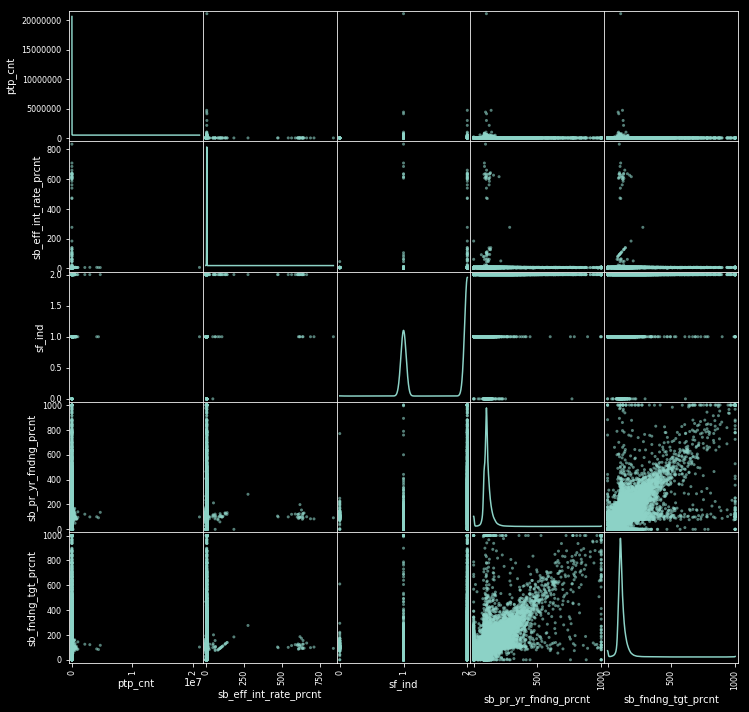

In [24]:
plt.style.use(['dark_background'])
scatter_matrix(X2, alpha=0.6, figsize=(12, 12), diagonal='kde')
plt.show()

<h3>EIR - restrict to values between 1 and 10 (appear to be invalid data entries)</h3>

In [100]:
len(X2[X2['ptp_cnt']>10000])

2670

In [104]:
X2[X2['ptp_cnt']>75000].describe()

,ptp_cnt,sb_eff_int_rate_prcnt,sf_ind,sb_pr_yr_fndng_prcnt,sb_fndng_tgt_prcnt
count,2.980000e+02,297.000000,298.000000,297.000000,297.000000
mean,3.150750e+05,6.364343,1.429530,105.046566,101.427374
std,1.303989e+06,0.438177,0.495842,21.895323,17.547844
min,7.527300e+04,3.460000,1.000000,0.000000,47.870000
25%,9.464700e+04,6.140000,1.000000,92.570000,92.880000
50%,1.381130e+05,6.340000,1.000000,103.810000,100.000000
75%,2.055002e+05,6.590000,2.000000,114.830000,105.910000
max,2.112766e+07,7.280000,2.000000,178.050000,173.230000


In [ ]:
plt.hist(X2[X2['ptp_cnt']<75000],bins=100)
plt.show()

KeyboardInterrupt: 

In [74]:
eir_nonzero = X2[(X2['sb_eff_int_rate_prcnt'] >1) & (X2['sb_eff_int_rate_prcnt'] < 10) \
                & (X2['sb_fndng_tgt_prcnt'] < 400) & (X2['sb_plan_type_code'] == '1')]
y_eirnonzero = eir_nonzero['sb_fndng_tgt_prcnt'].values

In [75]:
eir_nonzero.shape, y_eirnonzero.shape, eir_nonzero['sb_eff_int_rate_prcnt'].shape

((221164, 6), (221164,), (221164,))

In [76]:
eir_nonzero['sb_eff_int_rate_prcnt'].max()

9.98

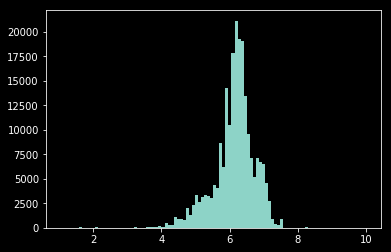

In [77]:
plt.hist(eir_nonzero['sb_eff_int_rate_prcnt'],bins=100)
plt.show()

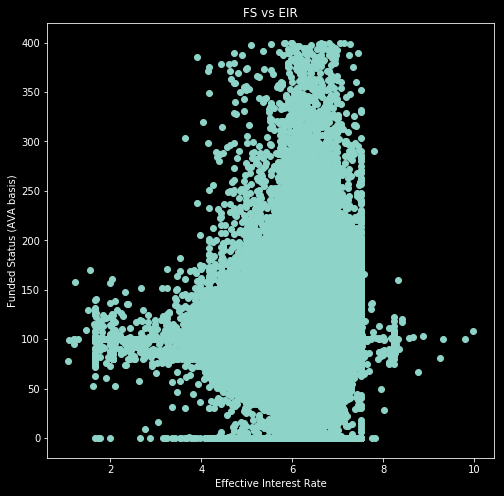

In [78]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
#plt.scatter(X['sb_pr_yr_fndng_prcnt'], y_fs)
plt.scatter(eir_nonzero['sb_eff_int_rate_prcnt'], y_eirnonzero)
plt.xlabel('Effective Interest Rate')
plt.ylabel('Funded Status (AVA basis)')
plt.title('FS vs EIR')
plt.show()

In [79]:
eir_nonzero['sb_fndng_tgt_prcnt'].describe()

count    221164.000000
mean        108.714161
std          32.460314
min           0.000000
25%          94.820000
50%         102.570000
75%         119.010000
max         399.890000
Name: sb_fndng_tgt_prcnt, dtype: float64

In [63]:
len(eir_nonzero[eir_nonzero['sb_fndng_tgt_prcnt']> 400])

677

In [ ]:
plt.hist(y_ava_fs,bins=100)
plt.show()

In [ ]:
y_ava_fs.min(), y_ava_fs.max()